In [1]:
exclude_models = [] # list of 4 digit hexa string or empty list

In [2]:
%%capture

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import yaml
from IPython.display import *
import ipywidgets as widgets
from ipywidgets import *
from IPython.display import Image, display
from LRFutils import progress
from scipy.optimize import curve_fit
import tensorflow as tf
from src import physical_models

2023-05-09 08:45:13.648146: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 08:45:13.793151: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-09 08:45:13.793177: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-09 08:45:13.830046: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-09 08:45:14.816162: W tensorflow/stream_executor/platform/de

In [3]:
# Loading models

# Getting list of model's archive path
source = f"data/model_comparison/model_list.yml"
with open(source) as f:
    archives = yaml.safe_load(f)

# Loading models
all_models = {}
print("Loading models:")
for model_number, archive in archives.items():

    try:
        details = json.load(open(f'{archive}/details.json'))
        model_id = details["model_id"]

        if model_id in exclude_models:
            continue

        history = np.load(f'{archive}/history.npz', allow_pickle=True)
        results = np.load(f'{archive}/predictions.npz', allow_pickle=True)["predictions"].item()

        print(f" - {model_number}: {archive}/details.json")
        print(f"      History keys: {', '.join(list(history.keys()))}")

        model = tf.keras.models.load_model(f'{archive}/model.h5')
        
        all_models[model_id] = {
            "archive": archive,
            "details": details,
            "history": history,
            "results": results,
            "model": model
        }
    except Exception as e:
        print("Could not load model", model_number)
        print(e)

Loading models:
 - 0000: ./archives/2023-05-02_8fbe00b/7/details.json
      History keys: loss, val_loss, Plummer_profile_1D_MAE, val_Plummer_profile_1D_MAE
 - 0001: ./archives/2023-05-02_8fbe00b/8/details.json
      History keys: loss, val_loss, Plummer_profile_1D_MAE, val_Plummer_profile_1D_MAE


2023-05-09 08:45:17.114499: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-09 08:45:17.114532: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-09 08:45:17.114553: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cluster16): /proc/driver/nvidia/version does not exist
2023-05-09 08:45:17.114769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 - 0002: ./archives/2023-05-02_8fbe00b/10/details.json
      History keys: loss, val_loss, Plummer_profile_1D_MAE, val_Plummer_profile_1D_MAE
 - 0003: ./archives/2023-05-03_8fbe00b/2/details.json
      History keys: loss, val_loss, Plummer_profile_1D_MAE, val_Plummer_profile_1D_MAE
 - 0004: ./archives/2023-05-03_8fbe00b/3/details.json
      History keys: loss, Plummer_max_loss, Plummer_radius_loss, Plummer_slope_loss, Plummer_max_MAE, Plummer_radius_MAE, Plummer_slope_MAE, val_loss, val_Plummer_max_loss, val_Plummer_radius_loss, val_Plummer_slope_loss, val_Plummer_max_MAE, val_Plummer_radius_MAE, val_Plummer_slope_MAE
 - 0005: ./archives/2023-05-03_8fbe00b/4/details.json
      History keys: loss, Plummer_max_loss, Plummer_radius_loss, Plummer_slope_loss, Plummer_max_MAE, Plummer_radius_MAE, Plummer_slope_MAE, val_loss, val_Plummer_max_loss, val_Plummer_radius_loss, val_Plummer_slope_loss, val_Plummer_max_MAE, val_Plummer_radius_MAE, val_Plummer_slope_MAE
 - 0006: ./archives/2023-05-03_

In [4]:
# Selecting model to compare

models = {}
def update_model_list_select(*args):
    global models
    models = {}
    for key in model_list_select.value:
        models[key] = all_models[key]

model_list_select = widgets.SelectMultiple(
    options=list(all_models.keys()),
    value=list(all_models.keys()),
    description='Models',
    disabled=False
)

model_list_select.observe(update_model_list_select)
display(model_list_select)
update_model_list_select()

SelectMultiple(description='Models', index=(0, 1, 2, 3, 4, 5, 6, 7, 8), options=('0000', '0001', '0002', '0003…

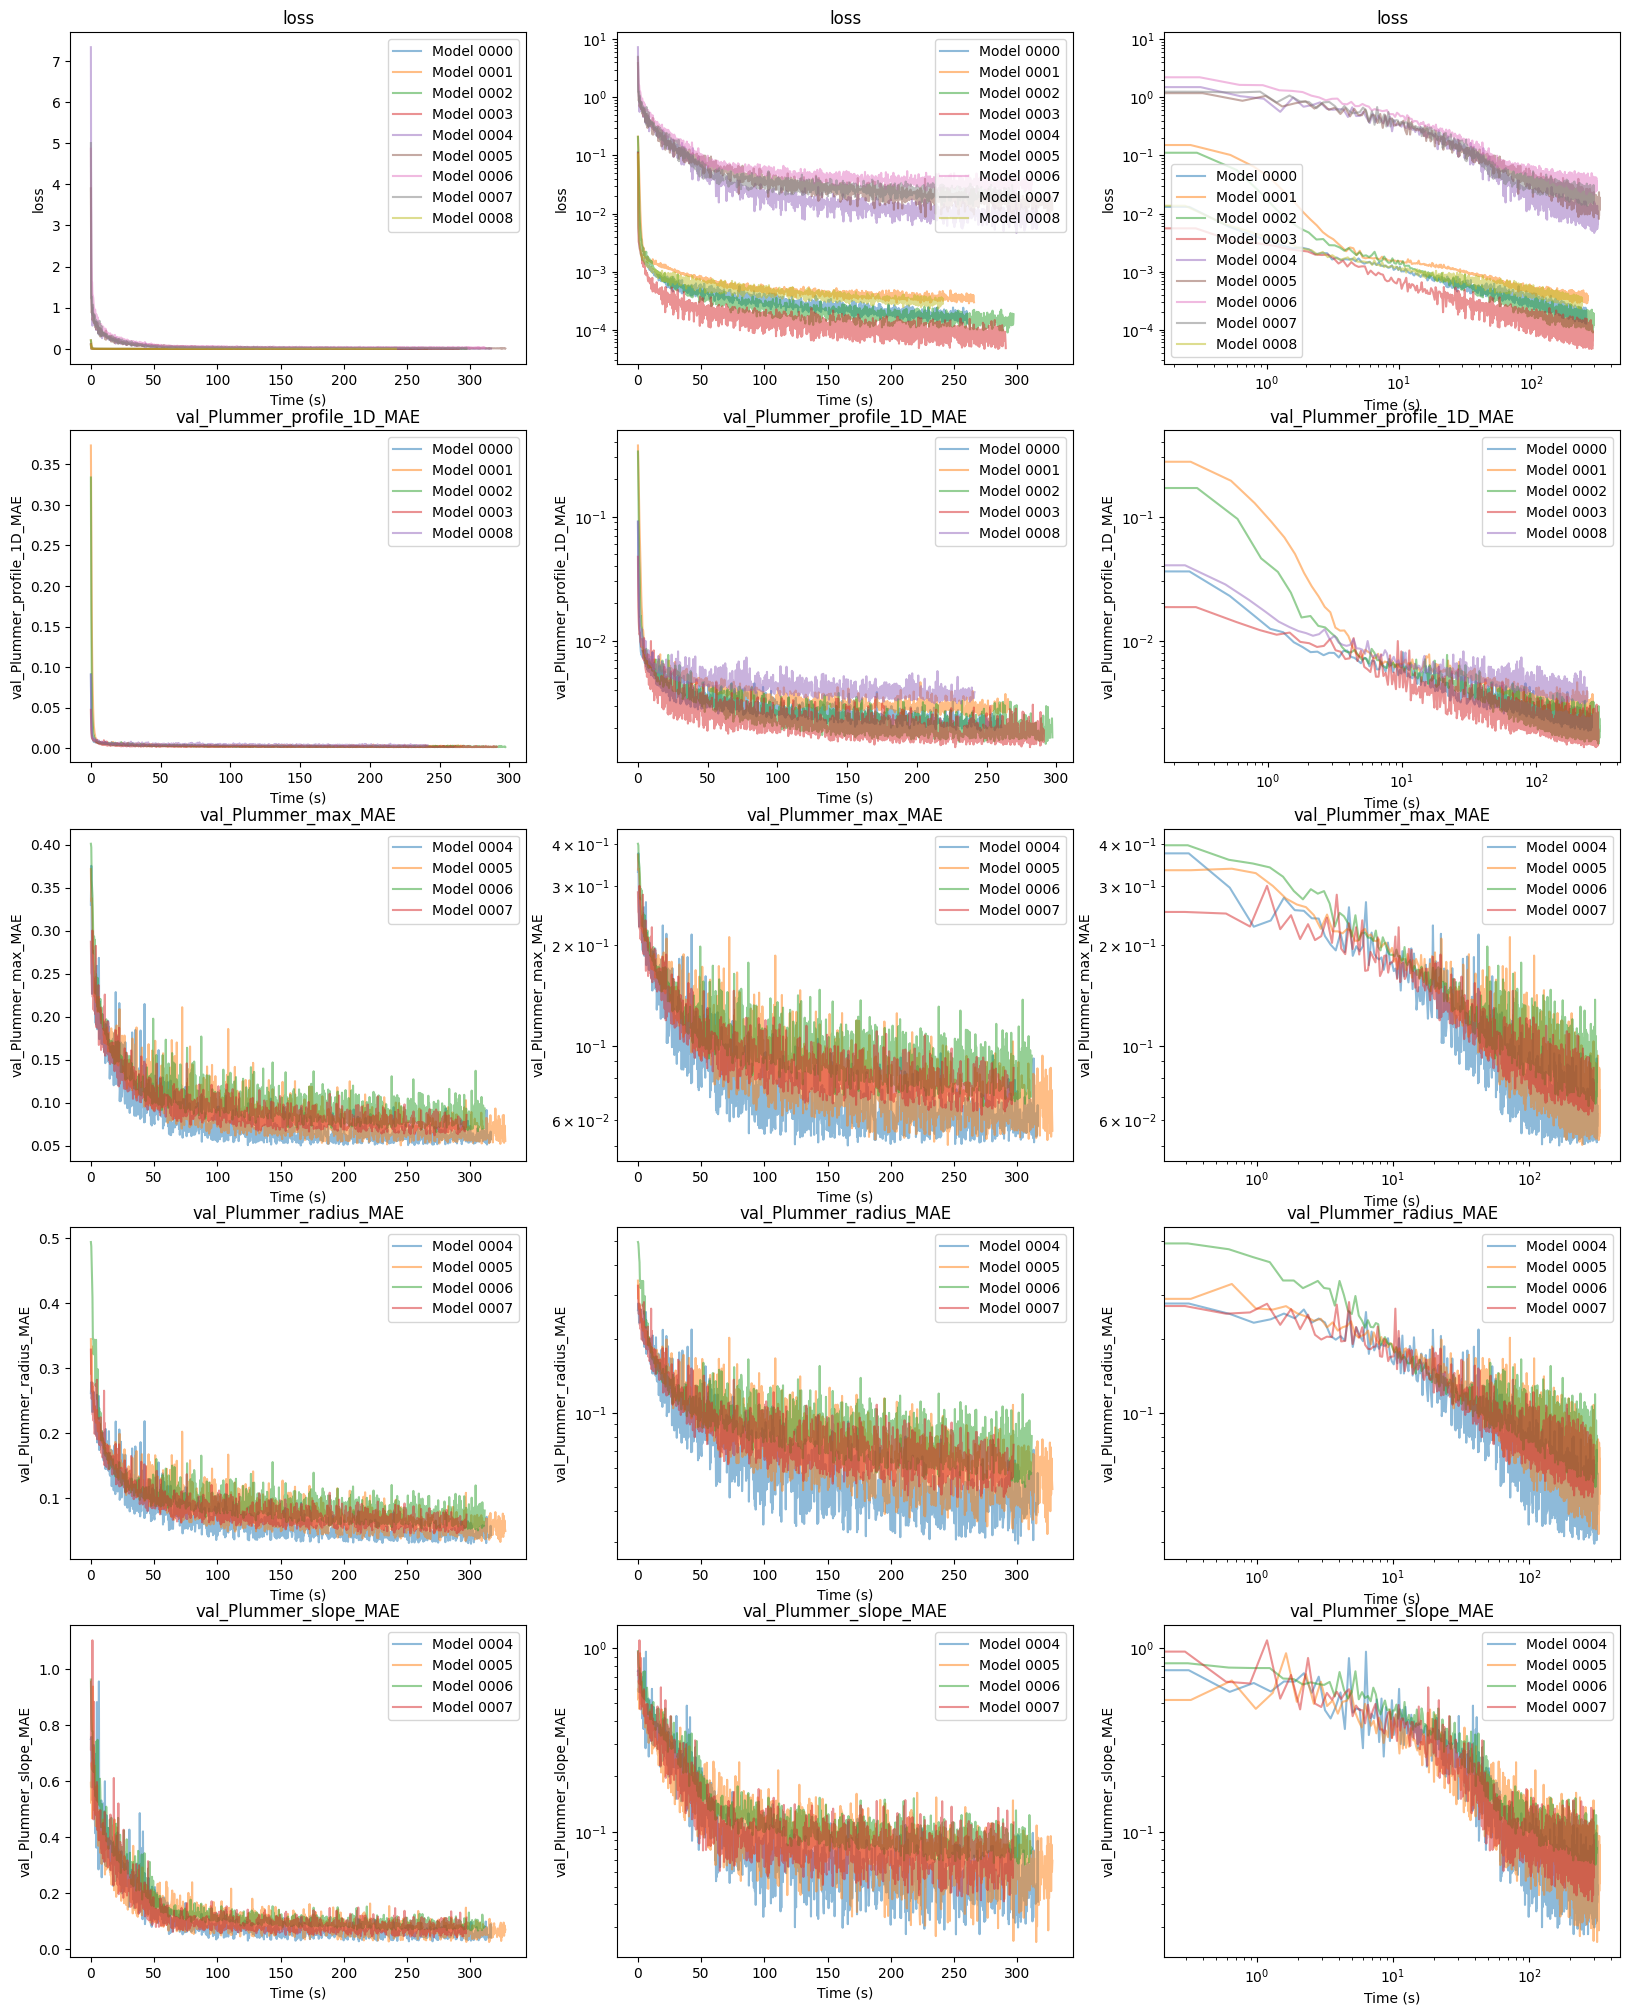

In [5]:
# Plot training evolution

# Looking at how many different val metrics are available
nb_metrics = 1
seen_metrics = ["loss"]
for model_id, model in models.items():
    for key in model["history"].keys():
        if key.startswith("val_") and not key.endswith("loss") and key not in seen_metrics:
            seen_metrics.append(key)
            nb_metrics += 1

fig, axs = plt.subplots(nb_metrics, 3, figsize=(20, 5*nb_metrics))

for model_id, model in models.items():

    history = model["history"]
    time_range = np.linspace(0, model["details"]["training_time"], model["details"]["epochs"], endpoint=True)

    # Printing loss
    for i, key in enumerate(seen_metrics):
        if key in history:
            for ax in axs[i]:
                curve = history[key]
                ax.plot(time_range, curve, alpha=0.5, label=f"Model {model_id}")


for i, row in enumerate(axs):
    for ax in row:
        ax.set_title(seen_metrics[i])
        ax.set_ylabel(seen_metrics[i])
        ax.set_xlabel('Time (s)')
        ax.legend()
    row[1].set_yscale('log')
    row[2].set_xscale('log')
    row[2].set_yscale('log')

plt.show()

In [6]:
# Model completion | Plummer profile 1D -> Plummer parameters

space_range = np.linspace(-25, 25, 64, endpoint=True)

def plummer_profile_to_parameter():
    global all_models; space_range

    treated_models = []

    for model_id, model in all_models.items():

        # Ignoring models that does not have the Plummer profile or that already have the parameters
        if not "Plummer_profile_1D" in model["results"] \
                or "Plummer_max"    in model["results"] \
                or "Plummer_radius" in model["results"] \
                or "Plummer_slope"  in model["results"]:
            continue

        treated_models.append(model_id)

        # Computing the Plummer parameters associated to each profile
        model["results"]["Plummer_max"]    = []
        model["results"]["Plummer_radius"] = []
        model["results"]["Plummer_slope"]  = []
        bar = progress.Bar(len(model["results"]["Plummer_profile_1D"]), prefix=f"Fitting plummer on {model_id}")
        i=0
        for output in model["results"]["Plummer_profile_1D"]:
            expectation, predictions = output["expectation"], output["predictions"]

            param = [1e4, 2, 1]
            expectation_popt, _ = curve_fit(physical_models.plummer, space_range, expectation, p0=param, maxfev = 100000)
            expectation_max = np.array([expectation_popt[0]])
            expectation_radius = np.array([expectation_popt[1]])
            expectation_slope = np.array([expectation_popt[2]])

            predictions_max = []
            predictions_radius = []
            predictions_slope = []
            for prediction in predictions:
                popt, _ = curve_fit(physical_models.plummer, space_range, prediction, p0=param, maxfev = 100000)
                predictions_max.append(np.array([popt[0]]))
                predictions_radius.append(np.array([popt[1]]))
                predictions_slope.append(np.array([popt[2]]))

            model["results"]["Plummer_max"].append({"expectation":expectation_max, "predictions":predictions_max})
            model["results"]["Plummer_radius"].append({"expectation":expectation_radius, "predictions":predictions_radius})
            model["results"]["Plummer_slope"].append({"expectation":expectation_slope, "predictions":predictions_slope})

            i+=1
            bar(i)

    return treated_models

profile_to_param_models = plummer_profile_to_parameter()

/home/vforiel/M2-Prestel-state-from-obs-ML/src/physical_models.py:23: RuntimeWarning: invalid value encountered in double_scalars
  profile = 3/(4 * np.pi * radius**3) * (1 + np.abs(space_range)**slope / radius**slope)**(-5/2)


Fitting plummer on 0000 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 100/100 0:00:01ta 0:00:00
Fitting plummer on 0001 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 100/100 0:00:04ta 0:00:00
Fitting plummer on 0002 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 100/100 0:00:02ta 0:00:00
Fitting plummer on 0003 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 100/100 0:00:01ta 0:00:00
Fitting plummer on 0008 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 100/100 0:00:01ta 0:00:00


Dropdown(description='Model: ', options=('0000', '0001', '0002', '0003', '0008'), value='0000')

IntSlider(value=0, continuous_update=False, description='Test:', layout=Layout(width='100%'), max=99)

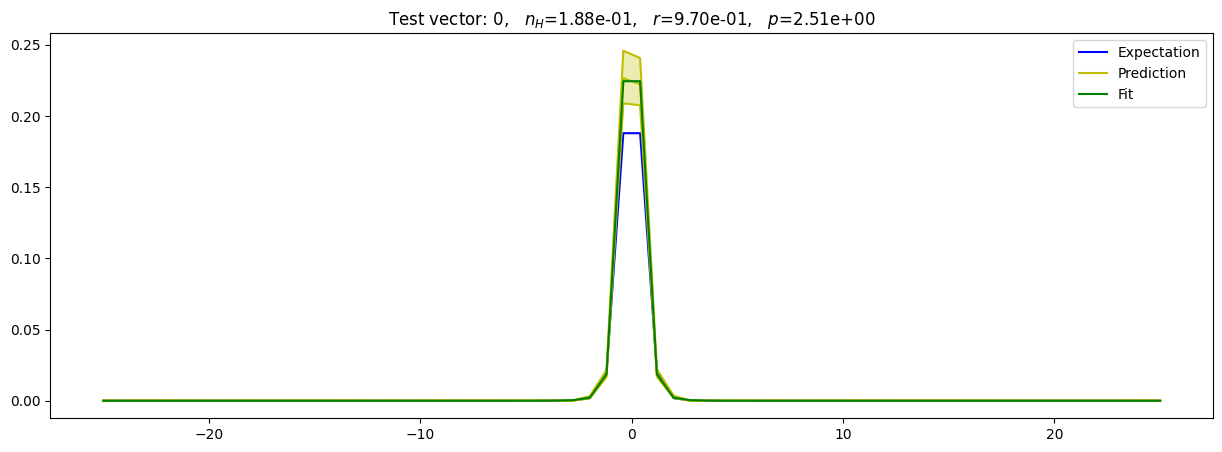

In [7]:
# Plotting comparison

profile_to_param_model_dropdown = Dropdown(options=profile_to_param_models, value=profile_to_param_models[0], description="Model: ")

def get_profile_to_param_result_slider():
    global profile_to_param_model_dropdown
    model = all_models[profile_to_param_model_dropdown.value]
    return IntSlider(
        value=0,
        min=0,
        max=len(model["results"]["Plummer_profile_1D"])-1,
        step=1,
        description='Test:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d',
        width='100%',
        layout=Layout(width='100%') 
    )

profile_to_param_result_slider = get_profile_to_param_result_slider()

def plot_profile_to_param(*args):
    global profile_to_param_model_dropdown, space_range, previous_button, next_button, profile_to_param_result_slider

    model = all_models[profile_to_param_model_dropdown.value]
    r = profile_to_param_result_slider.value

    clear_output()
    display(profile_to_param_model_dropdown)
    display(profile_to_param_result_slider)

    expectation = model["results"]["Plummer_profile_1D"][r]["expectation"]
    prediction_max = np.max(model["results"]["Plummer_profile_1D"][r]["predictions"], axis=0)
    prediction_mean = np.mean(model["results"]["Plummer_profile_1D"][r]["predictions"], axis=0)
    prediction_min = np.min(model["results"]["Plummer_profile_1D"][r]["predictions"], axis=0)

    plt.figure(figsize=(15, 5))

    plt.plot(space_range, expectation, c="b", label="Expectation")
    plt.plot(space_range, prediction_max, c="y", label="Prediction")
    plt.plot(space_range, prediction_mean, c="y")
    plt.plot(space_range, prediction_min, c="y")
    plt.fill(np.concatenate([space_range, space_range[::-1]]), np.concatenate([prediction_max, prediction_min[::-1]]), alpha=.3, c="y")


    param = [1,2, 1]
    popt, pcov = curve_fit(physical_models.plummer, space_range, prediction_mean, p0=param, maxfev = 100000)
    fit = physical_models.plummer(space_range, *popt)
    plt.plot(space_range, fit, c="g", label="Fit")
    # print(f"M = {popt[0]}, d = {popt[1]}, p = {popt[2]}")

    plt.title(
        f'Test vector: {r},   '
        + f'$n_H$={float(model["results"]["Plummer_max"][r]["expectation"]):.2e},   '\
        + f'$r$={float(model["results"]["Plummer_radius"][r]["expectation"]):.2e},   '\
        + f'$p$={float(model["results"]["Plummer_slope"][r]["expectation"]):.2e}'
    )
    plt.legend()

    plt.show()

def update_profile_to_param_result(*args):
    global profile_to_param_result
    profile_to_param_result = get_profile_to_param_result_slider()
    plot_profile_to_param()

profile_to_param_model_dropdown.observe(update_profile_to_param_result)
profile_to_param_result_slider.observe(plot_profile_to_param)

plot_profile_to_param()

In [8]:
# Model completion | Plummer parameters -> Plummer profile 1D

def plummer_parameter_to_profile():
    global all_models, space_range

    treated_models = []

    for model_id, model in all_models.items():

        # Ignoring models that does not have the Plummer parameters or that already have the profile
        if "Plummer_profile_1D" in model["results"] \
                or not "Plummer_max"    in model["results"] \
                or not "Plummer_radius" in model["results"] \
                or not "Plummer_slope"  in model["results"]:
            continue

        treated_models.append(model_id)

        # Computing the Plummer parameters associated to each profile
        model["results"]["Plummer_profile_1D"]    = []
        bar = progress.Bar(len(model["results"]["Plummer_max"]), prefix=f"Fitting plummer on {model_id}")
        for i in range(len(model["results"]["Plummer_max"])):

            expectation_max = model["results"]["Plummer_max"][i]["expectation"]
            expectation_radius = model["results"]["Plummer_radius"][i]["expectation"]
            expectation_slope = model["results"]["Plummer_slope"][i]["expectation"]

            expectation_profile = physical_models.plummer(space_range, expectation_max, expectation_radius, expectation_slope)

            predictions_profile = []
            for j in range(len(model["results"]["Plummer_max"][i]["predictions"])):

                prediction_max = model["results"]["Plummer_max"][i]["predictions"][j]
                prediction_radius = model["results"]["Plummer_radius"][i]["predictions"][j]
                prediction_slope = model["results"]["Plummer_slope"][i]["predictions"][j]
                
                profile = physical_models.plummer(space_range, prediction_max, prediction_radius, prediction_slope)

                predictions_profile.append(profile)

            model["results"]["Plummer_profile_1D"].append({"expectation":expectation_profile, "predictions":predictions_profile})

            bar(i+1)

    return treated_models

param_to_profile_models = plummer_parameter_to_profile()          

Fitting plummer on 0004 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 100/100 0:00:00 eta -
Fitting plummer on 0005 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 100/100 0:00:00 eta -
Fitting plummer on 0006 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 100/100 0:00:00 eta -
Fitting plummer on 0007 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 100/100 0:00:00 eta -


/home/vforiel/M2-Prestel-state-from-obs-ML/src/physical_models.py:23: RuntimeWarning: divide by zero encountered in divide
  profile = 3/(4 * np.pi * radius**3) * (1 + np.abs(space_range)**slope / radius**slope)**(-5/2)
/home/vforiel/M2-Prestel-state-from-obs-ML/src/physical_models.py:23: RuntimeWarning: invalid value encountered in multiply
  profile = 3/(4 * np.pi * radius**3) * (1 + np.abs(space_range)**slope / radius**slope)**(-5/2)


Dropdown(description='Model: ', options=('0004', '0005', '0006', '0007'), value='0004')

IntSlider(value=0, continuous_update=False, description='Test:', layout=Layout(width='100%'), max=99)

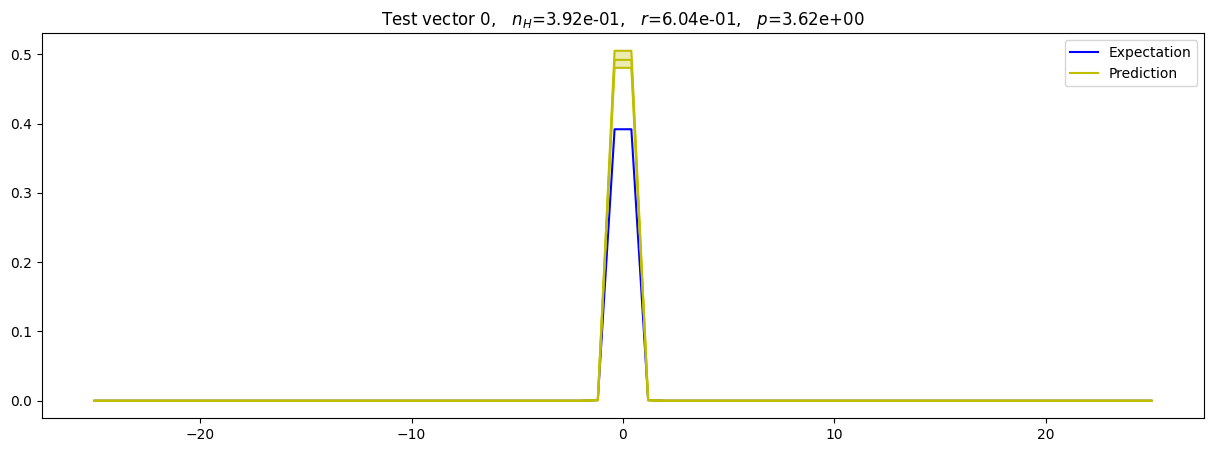

In [9]:
# Plotting comparison

param_to_profile_model_dropdown = Dropdown(options=param_to_profile_models, value=param_to_profile_models[0], description="Model: ")

def get_param_to_profile_result_slider():
    global profile_to_param_model_dropdown
    model = all_models[param_to_profile_model_dropdown.value]
    return IntSlider(
        value=0,
        min=0,
        max=len(model["results"]["Plummer_profile_1D"])-1,
        step=1,
        description='Test:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d',
        width='100%',
        layout=Layout(width='100%') 
    )

param_to_profile_result_slider = get_param_to_profile_result_slider()

def plot_param_to_profile(*args):
    global param_to_profile_model_dropdown, space_range, previous_button, next_button, param_to_profile_result_slider

    model = all_models[param_to_profile_model_dropdown.value]
    r = profile_to_param_result_slider.value

    clear_output()
    display(param_to_profile_model_dropdown)
    display(param_to_profile_result_slider)

    expectation = model["results"]["Plummer_profile_1D"][r]["expectation"]
    prediction_max = np.max(model["results"]["Plummer_profile_1D"][r]["predictions"], axis=0)
    prediction_mean = np.mean(model["results"]["Plummer_profile_1D"][r]["predictions"], axis=0)
    prediction_min = np.min(model["results"]["Plummer_profile_1D"][r]["predictions"], axis=0)

    plt.figure(figsize=(15, 5))

    expectation = model["results"]["Plummer_profile_1D"][r]["expectation"]
    prediction_max = np.max(model["results"]["Plummer_profile_1D"][r]["predictions"], axis=0)
    prediction_mean = np.mean(model["results"]["Plummer_profile_1D"][r]["predictions"], axis=0)
    prediction_min = np.min(model["results"]["Plummer_profile_1D"][r]["predictions"], axis=0)

    plt.plot(space_range, expectation, c="b", label="Expectation")
    plt.plot(space_range, prediction_max, c="y", label="Prediction")
    plt.plot(space_range, prediction_mean, c="y")
    plt.plot(space_range, prediction_min, c="y")
    plt.fill(np.concatenate([space_range, space_range[::-1]]), np.concatenate([prediction_max, prediction_min[::-1]]), alpha=.3, c="y")

    plt.title(
        f'Test vector {r},   '
        + f'$n_H$={float(model["results"]["Plummer_max"][r]["expectation"]):.2e},   '\
        + f'$r$={float(model["results"]["Plummer_radius"][r]["expectation"]):.2e},   '\
        + f'$p$={float(model["results"]["Plummer_slope"][r]["expectation"]):.2e}'
    )

    plt.legend()
    plt.show()

def update_param_to_profile_result(*args):
    global param_to_profile_result
    param_to_profile_result = get_param_to_profile_result_slider()
    plot_param_to_profile()

param_to_profile_model_dropdown.observe(update_param_to_profile_result)
param_to_profile_result_slider.observe(plot_param_to_profile)

plot_param_to_profile()

In [10]:
# Violin plot def

def violin_plot(output, model_list, limits):
    plt.figure(figsize=(20, 10))

    labels = []
    def add_label(violin, label):
        color = violin["bodies"][0].get_facecolor().flatten()
        labels.append((mpatches.Patch(color=color), label))

    i = 0
    ignored_models = []
    for key in model_list:
        model = models[key]

        if output not in model["results"]:
            ignored_models.append(key)
            continue

        # print(model["details"]["model_id"])

        results = model["results"][output]

        expectations = np.array([results[i]["expectation"] for i in range(len(results))])
        predictions = np.array([results[i]["predictions"] for i in range(len(results))])

        expectations = expectations.flatten()
        dim_order = list(range(len(predictions.shape)))
        dim_order.pop(1)
        dim_order.append(1)
        predictions = np.transpose(predictions, dim_order)
        N = predictions.shape[-1]
        S = predictions.size
        predictions = predictions.reshape((S//N,N)).T
        
        vmin = float(limits[0])
        vmax = float(limits[1])
        eps = (float(limits[1]) - float(limits[0])) * 0.01

        mask = (expectations + eps >= vmin) & (expectations - eps <= vmax)
        expectations = np.sort(expectations[mask], axis=0)
        predictions = np.sort(predictions[:,mask], axis=1)
        plt.scatter(expectations, expectations, color="k", alpha=1, s=10)

        # grouping expectations
        group_width = 1/20 * (np.max(expectations)-np.min(expectations))
        grouped_expectations = [expectations[0]]
        grouped_predictions = [predictions[:,0]]
        cpt = 1
        for i, expectation in enumerate(expectations):
            if i==0:
                continue
            if expectation - group_width < grouped_expectations[-1]:
                grouped_predictions[-1] += predictions[:,i]
                cpt += 1
            else:
                grouped_predictions[-1] /= cpt
                grouped_expectations.append(expectation)
                grouped_predictions.append(predictions[:,i])
                cpt = 1
        grouped_predictions[-1] /= cpt

        expectations = np.array(grouped_expectations)
        predictions = np.array(grouped_predictions).T

        emin = np.min(expectations)
        emax = np.max(expectations)

        plt.plot([emin,emax],[emin,emax], c="black", linewidth=1)

        violin_parts = plt.violinplot(
            dataset=predictions[:,:],
            positions=expectations[:], 
            widths=(np.max(expectations)-np.min(expectations))*0.05, showmeans=True, showextrema=False
        )

        add_label(violin_parts, f"Model {key}")

    if len(ignored_models) > 0:
        print(f"Ignored models that doens't have the {output} output: {', '.join(ignored_models)}")
 
    plt.title(f'Model predictions on {output}')
    plt.ylabel('Predictions')
    plt.xlabel('Expected')
    plt.ticklabel_format(axis="both", style='sci', scilimits=(0,0))
    plt.grid()
    plt.legend(*zip(*labels), loc=2)
    plt.show()

In [11]:
# Show violin plot

# Second model filter------------------------------------------------------------------------

plot_model_list_select = widgets.SelectMultiple(
    options=list(models.keys()),
    value=list(models.keys()),
    description='Plot models',
    disabled=False
)

# Select output among the possible  ---------------------------------------------------------

def get_output_dropdown():
    possible_outputs = []
    for key in plot_model_list_select.value:
        for output_label in models[key]["results"].keys():
            if output_label not in possible_outputs:
                possible_outputs.append(output_label)
    return Dropdown(options=possible_outputs, value=possible_outputs[0], description="Output: "), possible_outputs
output_dropdown, possible_outputs = get_output_dropdown()

# Select range of expectations in the output value's space ----------------------------------

def get_expectation_slider():
    possible_expectations = np.array([])
    for model in models.values():
        if output_dropdown.value not in model["results"]:
            continue

        expectations = np.array([output["expectation"] for output in model["results"][output_dropdown.value]])
        possible_expectations = np.concatenate((
            possible_expectations,
            expectations.flatten()
        ))
    possible_expectations = list(map(lambda x: f"{x:.2e}", np.sort(possible_expectations).tolist()))
    return widgets.SelectionRangeSlider(
        options=possible_expectations,
        index=(0, len(possible_expectations)-1),
        description='Range',
        disabled=False,
        width='100%',
        layout=Layout(width='100%')  
    )
expectation_slider = get_expectation_slider()

# Plot button ------------------------------------------------------------------------------

plot_button = widgets.Button(
    description='Plot',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

# Update GUI on action ---------------------------------------------------------------------

def update_gui(*args):
    clear_output()
    display(plot_model_list_select)
    display(output_dropdown)
    display(expectation_slider)
    display(plot_button)

def update_expectation_slider(*args):
    global expectation_slider
    expectation_slider = get_expectation_slider()
    update_gui()

def update_output_dropdown(*args):
    global expectation_slider, output_dropdown, possible_outputs, plot_model_list_select
    new_output_dropdown, new_possible_outputs = get_output_dropdown()
    if possible_outputs != new_possible_outputs:
        old_select = output_dropdown.value
        output_dropdown, possible_outputs = new_output_dropdown, new_possible_outputs
        if old_select in possible_outputs:
            output_dropdown.value = old_select
        else:
            expectation_slider = get_expectation_slider()
        update_gui()

def update_violin_plot(*args):
    update_gui()
    violin_plot(output_dropdown.value, plot_model_list_select.value, expectation_slider.value)
    
plot_model_list_select.observe(update_output_dropdown)
output_dropdown.observe(update_expectation_slider)
plot_button.on_click(update_violin_plot)
update_gui()


SelectMultiple(description='Plot models', index=(0, 1, 2, 3, 4, 5, 6, 7, 8), options=('0000', '0001', '0002', …

Dropdown(description='Output: ', options=('Plummer_profile_1D', 'Plummer_max', 'Plummer_radius', 'Plummer_slop…

SelectionRangeSlider(description='Range', index=(0, 57598), layout=Layout(width='100%'), options=('1.09e-17', …

Button(button_style='success', description='Plot', icon='check', style=ButtonStyle(), tooltip='Click me')

Dropdown(description='Model ID: ', options=('0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0…

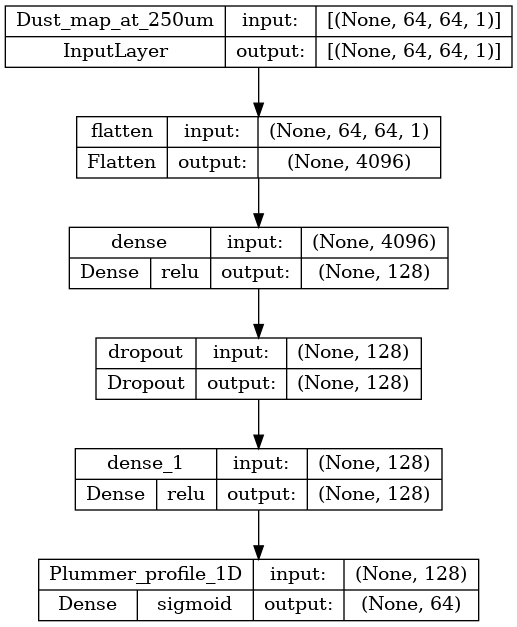

Total params: 549,184
Trainable params: 549,184
Non-trainable params: 0
_________________________________________________________________

Optimizer: RMSprop
Loss: mean_squared_error
Metrics:
 - MAE

Epochs: 1000
Batch size: 100

Training time: 4m 20.45s
Score:
 - 1.55e-04
 - 1.81e-03

Validation fraction: 20 %
Test fraction: 10 %

Path: ./archives/2023-05-02_8fbe00b/7



In [12]:
# Select model and view details

def print_model_details(id):

    model = all_models[id]
    archive = model["archive"]
    details = model["details"]

    display(Image(filename=f'{archive}/model.png'))
    print("\n".join(details['summary'][-4:]))

    print("")
    print("Optimizer:", details['optimizer'])
    if isinstance(details['loss'], list):
        print("Loss:\n -", "\n - ".join(details['loss']))
    else:
        print("Loss:", details['loss'])
    print("Metrics:\n -", "\n - ".join(details['metrics']))
    print("")
    print("Epochs:", details['epochs'])
    print("Batch size:", details['batch_size'])
    print("")
    print(f"Training time: {int(details['training_time']//60)}m {details['training_time']%60:.2f}s" )
    print("Score:\n -", "\n - ".join([f"{i:.2e}" for i in details['scores']]))
    print("")
    # print("Dataset size:", details['dataset_size'])
    print("Validation fraction:", int(details['val_frac'] * 100), "%")
    print("Test fraction:", int(details['test_frac'] * 100), "%")
    print("")
    print("Path:", archive)
    print("")
    if "inputs" in details:
        print("Inputs:\n -", "\n - ".join(details['inputs']))
    if "outputs" in details:
        print("Outputs:\n -", "\n - ".join(details['outputs']))

options = []
for model in all_models.values():
    options.append(model["details"]["model_id"])

selected_model = options[0]

model_widget = Dropdown(options=options, value=options[0], description="Model ID: ")

# Define a function that updates the content of y based on what we select for x
def update_model_widget(*args):
    global selected_model
    clear_output()
    display(model_widget)
    print_model_details(model_widget.value)
    selected_model = all_models[model_widget.value]

model_widget.observe(update_model_widget)
update_model_widget()